Imports

In [1]:
import os
import scipy as sp
import numpy as np
import time
from matplotlib import pyplot as plt
from pylab import *
from stereoid.oceans.forward_models import SAR_spectra as SAR_model
from stereoid.instrument import ObsGeo
import drama.geo as sargeo
from stereoid.oceans.waves.wave_spectra import elfouhaily
from stereoid.oceans.waves.wave_spectra import elfouhaily_spread

# output folder
outpath='/Users/marcelmac/Documents/Papers/BistaticSARtransform/'

# Run ID
mode = "IWS"
run_id='2021_1'

# stereoid path
path='/Users/marcelmac//Data/Harmony'
pardir=path + '/PAR/'
parfile=pardir + 'Hrmny_' + run_id + '.cfg'
main_dir=path + ''

Set some geometry

In [2]:
# Incident angle
incm = np.deg2rad(35)
along_track_separation=350E3 # should be consistent with the PAR file
swth_bst = sargeo.SingleSwathBistatic(par_file=parfile, dau=along_track_separation)
# Observation geometry calculated from orbit
obsgeo = ObsGeo.from_swath_geo(incm, swth_bst, ascending=True)
# receiver/transmitter range
Ix=np.argmin(np.absolute(incm-np.degrees(swth_bst.master_inc[0,:])))
Rt=swth_bst.master_range[0,Ix]
Rr=swth_bst.slave_range[0,Ix]
# angles
bist_ang=obsgeo.bist_ang
inc_m=obsgeo.inc_m
inc_b=obsgeo.inc_b
# rotation angle for MACS and cut-off
alpha_rot=np.arctan(np.sin(bist_ang)*np.sin(inc_b)/(np.sin(inc_m)+ np.cos(bist_ang)*np.sin(inc_b)))

Make a spectrum

In [3]:
# wave numbers in a Cartesian grids (kx=cross,ky=along)
g = 9.81
scene_size = 5000  # maximum wavelength (size of image)
dx = 10
dy = 20
Nx=int(scene_size/dx)
Ny=int(scene_size/dy)
kx = np.ones( (1, Nx) )
ky = np.ones( (Ny, 1) )
dk = 2 * np.pi / scene_size  # fundamental frequency
kx[ 0, 0:int( Nx / 2 ) ] = dk * np.arange( 0, Nx / 2 )
kx[ 0, int( Nx / 2 ): ] = dk * np.arange( -Nx / 2, 0 )
kx = np.dot( np.ones( (Ny, 1) ), kx )
ky[ 0:int( Ny / 2 ), 0 ] = dk * np.arange( 0, Ny / 2 )
ky[ int( Ny / 2 ):, 0 ] = dk * np.arange( -Ny / 2, 0 )
ky = np.dot( ky, np.ones( (1, Nx) ) )
k = np.sqrt( kx ** 2 + ky ** 2 )
omega = np.sqrt( g * k )  # angular velocity
phi = np.arctan2( ky, kx )  # 0 is cross-track direction waves, 90 along-track
shp=k.shape

Compute variances

1.3504358626071609


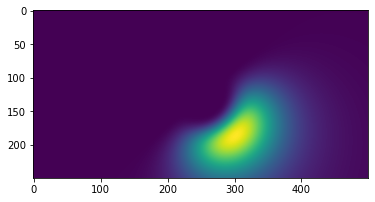

In [4]:
# wind-wave settings
phi_w = np.deg2rad(50)
u10 = 10
IWA = 1.1

# compute fetch from inverse wave age
X_0 = 22E3
X = np.arctanh( (IWA / 0.84) ** (-1 / 0.75) ) ** (1 / 0.4) * X_0
k_0 = g / u10 ** 2
fetch = X / k_0

# compute wave-spectrum spectrum
Sp = elfouhaily( k, u10, fetch )
dphi = (phi_w - phi + np.pi) % (2 * np.pi) - np.pi  # including unwrapping
D = elfouhaily_spread( k, dphi, u10, fetch )
S = Sp * D / k
S[ 0, 0 ] = 0

plt.imshow(np.fft.fftshift(S))
print(np.sqrt(np.sum(S*dk*dk))*4)

# scaling for input into fft (2*pi-scaling inside of the correlation functions)
S=S*dk*dk*Nx*Ny

# get cross-correlations
wn_grid={"S": S,"k_x": kx,"k_y": ky}
T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_m, np.radians(0.0001), mtf = 'Kirchhoff' )
II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_m, np.radians(0.0001), Rt, Rt )
Pm=np.exp(-ky**2*yy[0,0]-kx**2*xx[0,0]-kx*ky*(xy[0,0]+yx[0,0]))

T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_b, bist_ang, mtf = 'Kirchhoff' )
II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_b, bist_ang, Rt, Rr )
Pf=np.exp(-ky**2*yy[0,0]-kx**2*xx[0,0]-kx*ky*(xy[0,0]+yx[0,0]))

T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_b, -bist_ang, mtf = 'Kirchhoff' )
II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_b, -bist_ang, Rt, Rr )
Pb=np.exp(-ky**2*yy[0,0]-kx**2*xx[0,0]-kx*ky*(xy[0,0]+yx[0,0]))

Plots

/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_25965/2384692459.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('PuRd', 15)


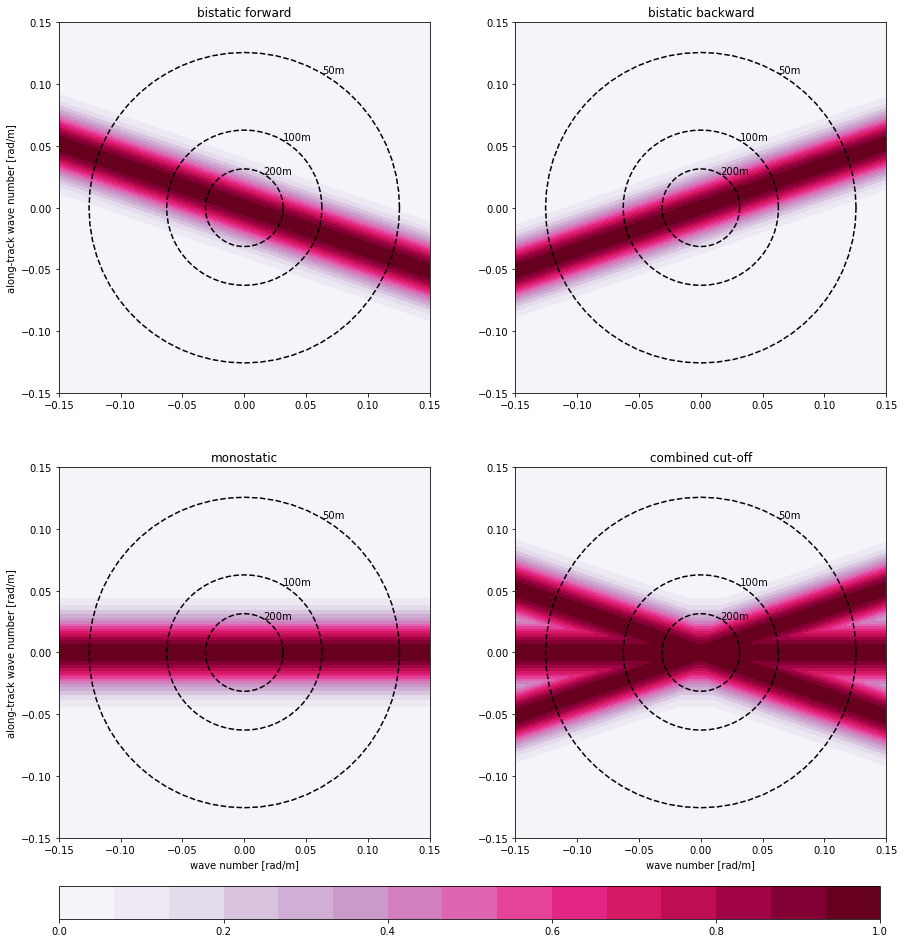

In [5]:
# wavelength circles
k100=2*np.pi/100;
k200=2*np.pi/200;
k50=2*np.pi/50;
ph=np.linspace(0,2*np.pi,61)
kx50=np.cos(ph)*k50
ky50=np.sin(ph)*k50
kx100=np.cos(ph)*k100
ky100=np.sin(ph)*k100
kx200=np.cos(ph)*k200
ky200=np.sin(ph)*k200


fig=plt.figure(figsize=(15,15))
cmap=cm.get_cmap('PuRd', 15)
# bi-static case (forward)
plt.subplot(2,2,1)
plt.imshow(np.fft.fftshift(Pf),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap=cmap, origin='lower',vmin=0,vmax=1)
plt.title('bistatic forward')
plt.ylabel('along-track wave number [rad/m]')
plt.plot(kx50,ky50,'k--')
plt.plot(kx100,ky100,'k--')
plt.plot(kx200,ky200,'k--')
plt.text(kx50[10],ky50[10],'50m',color='k')
plt.text(kx100[10],ky100[10],'100m',color='k')
plt.text(kx200[10],ky200[10],'200m',color='k')
plt.xlim(-0.15,0.15)
plt.ylim(-0.15,0.15)

# mono-static case
#P=P2/np.max(P2)
plt.subplot(2,2,2)
plt.imshow(np.fft.fftshift(Pb),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap=cmap, origin='lower',vmin=0,vmax=1)
plt.title('bistatic backward')
plt.plot(kx50,ky50,'k--')
plt.plot(kx100,ky100,'k--')
plt.plot(kx200,ky200,'k--')
plt.text(kx50[10],ky50[10],'50m',color='k')
plt.text(kx100[10],ky100[10],'100m',color='k')
plt.text(kx200[10],ky200[10],'200m',color='k')
plt.xlim(-0.15,0.15)
plt.ylim(-0.15,0.15)

# bi-static case (forward)
#P=P3/np.max(P3)
plt.subplot(2,2,3)
plt.imshow(np.fft.fftshift(Pm),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap=cmap, origin='lower',vmin=0,vmax=1)
plt.title('monostatic')
plt.ylabel('along-track wave number [rad/m]')
plt.xlabel('wave number [rad/m]')
plt.plot(kx50,ky50,'k--')
plt.plot(kx100,ky100,'k--')
plt.plot(kx200,ky200,'k--')
plt.text(kx50[10],ky50[10],'50m',color='k')
plt.text(kx100[10],ky100[10],'100m',color='k')
plt.text(kx200[10],ky200[10],'200m',color='k')
plt.xlim(-0.15,0.15)
plt.ylim(-0.15,0.15)

# combined
P=np.maximum(np.maximum(Pf,Pb),Pm)
plt.subplot(2,2,4)
img=plt.imshow(np.fft.fftshift(P),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap=cmap, origin='lower',vmin=0,vmax=1)
plt.title('combined cut-off')
plt.xlabel('wave number [rad/m]')
plt.plot(kx50,ky50,'k--')
plt.plot(kx100,ky100,'k--')
plt.plot(kx200,ky200,'k--')
plt.text(kx50[10],ky50[10],'50m',color='k')
plt.text(kx100[10],ky100[10],'100m',color='k')
plt.text(kx200[10],ky200[10],'200m',color='k')
plt.xlim(-0.15,0.15)
plt.ylim(-0.15,0.15)

# add the colorbars
cbaxes = fig.add_axes([0.13, 0.05, 0.76, 0.03]) 
cb = plt.colorbar(img, cax = cbaxes, orientation='horizontal')
plt.savefig(outpath + 'Cutoff.png',dpi=300)